<a href="https://colab.research.google.com/github/prateekmanral011/Earthquake-forecasting/blob/main/plotting_zones_and_focal_mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas obspy shapely pyproj --quiet   # (once per session)

from google.colab import files
files.upload()                                        # select the five NE shapefile parts,
                                                     # gadm41_IND_0.json, gadm41_IND_1.json,
                                                     # and final_3.csv

# Paste the full script above and execute.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


{}

Enter minimum magnitude to plot (e.g., 6.0): 6.5


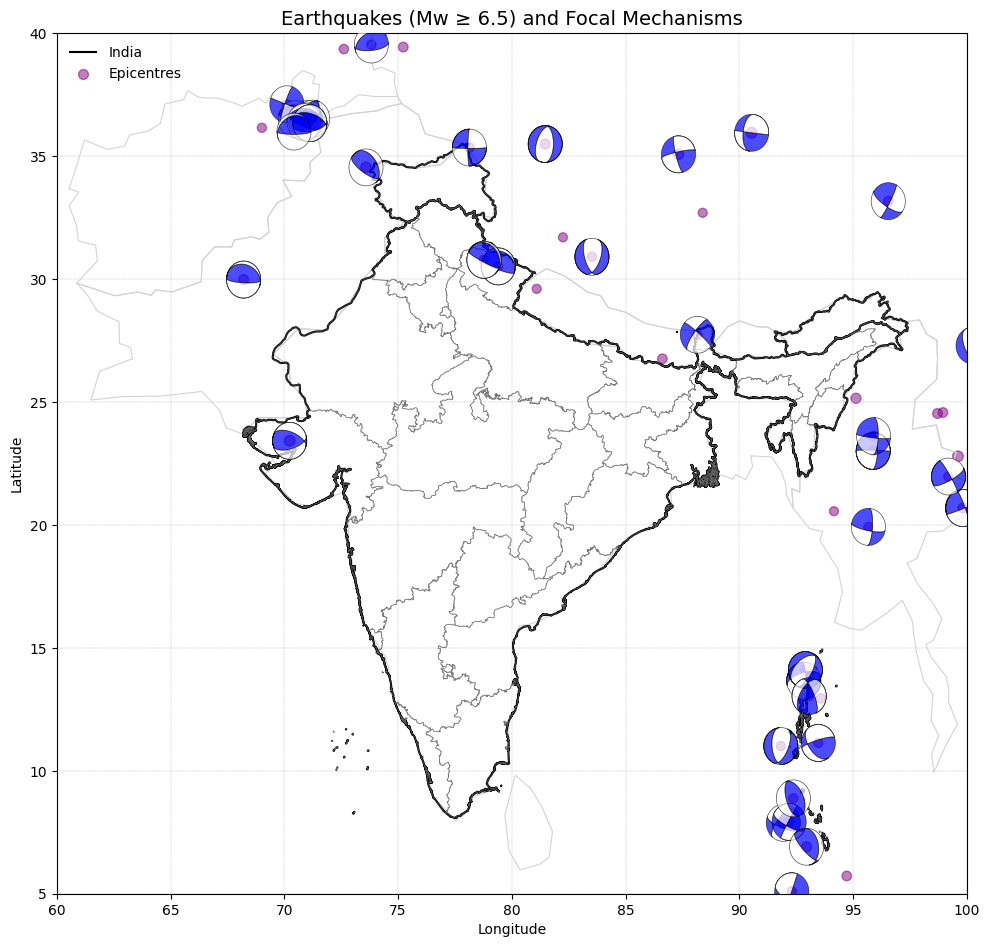

In [ ]:
# =========================================================
#  Earthquakes & focal mechanisms on India–subcontinent map
# =========================================================
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from obspy.imaging.beachball import beach
import numpy as np

# ------------------------- USER INPUT --------------------
mag_threshold = float(input("Enter minimum magnitude to plot (e.g., 6.0): "))

# ---------------- 1) LOAD & FILTER CATALOG ---------------
df = pd.read_csv("final_3.csv")            # latitude, longitude, mag, strike, dip, rake
df = df[df["mag"] >= mag_threshold]        # magnitude cut

geometry = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
gdf_eq = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# ---------------- 2) LOAD COUNTRY / STATE BORDERS --------
# (a) Sub-continent outlines from uploaded Natural Earth shapefile
ne_path = "/content/ne_110m_admin_0_countries.shp"
world   = gpd.read_file(ne_path).to_crs("EPSG:4326")
region  = world[world["NAME"].isin([
    "India", "Nepal", "Pakistan", "Bangladesh", "Myanmar",
    "Bhutan", "Sri Lanka", "China", "Afghanistan"
])]

# (b) India high-resolution GADM boundaries
india0 = gpd.read_file("/content/gadm41_IND_0.json").to_crs("EPSG:4326")  # national
india1 = gpd.read_file("/content/gadm41_IND_1.json").to_crs("EPSG:4326")  # states

# ---------------- 3) PLOT BASE MAP ------------------------
fig, ax = plt.subplots(figsize=(10, 12))

# Sub-continent neighbours
region.boundary.plot(ax=ax, color="lightgray", linewidth=0.8, label="_nolegend_")

# India outline + states
india0.boundary.plot(ax=ax, color="black", linewidth=1.5, label="India")
india1.boundary.plot(ax=ax, color="dimgray", linewidth=0.5, alpha=0.7, label="_nolegend_")

# ---------------- 4) EPICENTRES & BEACHBALLS --------------
gdf_eq.plot(
    ax=ax,
    markersize=gdf_eq["mag"] ** 2,
    color="purple",
    alpha=0.5,
    label="Epicentres"
)

for _, row in df.iterrows():
    strike, dip, rake = row[['strike', 'dip', 'rake']]
    lat, lon           = row[['latitude', 'longitude']]

    if np.isnan([strike, dip, rake]).any():
        continue  # skip incomplete mechanisms

    # Beach-ball (focal mechanism)
    bball = beach([strike, dip, rake],
                  width=1.5,
                  xy=(lon, lat),
                  linewidth=0.5,
                  facecolor="blue",
                  alpha=0.7)
    ax.add_collection(bball)

# ---------------- 5) COSMETICS ----------------------------
ax.set_xlim(60, 100)
ax.set_ylim(5, 40)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", linewidth=0.3)

plt.title(f"Earthquakes (Mw ≥ {mag_threshold}) and Focal Mechanisms", fontsize=14)
plt.legend(loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


✅ Himalayan_Arc: 196 events written
✅ Lower_Himalayan_Arc: 285 events written
✅ Indo_Burmese_Arc: 373 events written
✅ Kirthar_Sulaiman_Range: 217 events written
✅ Hindukush: 721 events written
✅ Andaman_Subduction: 555 events written


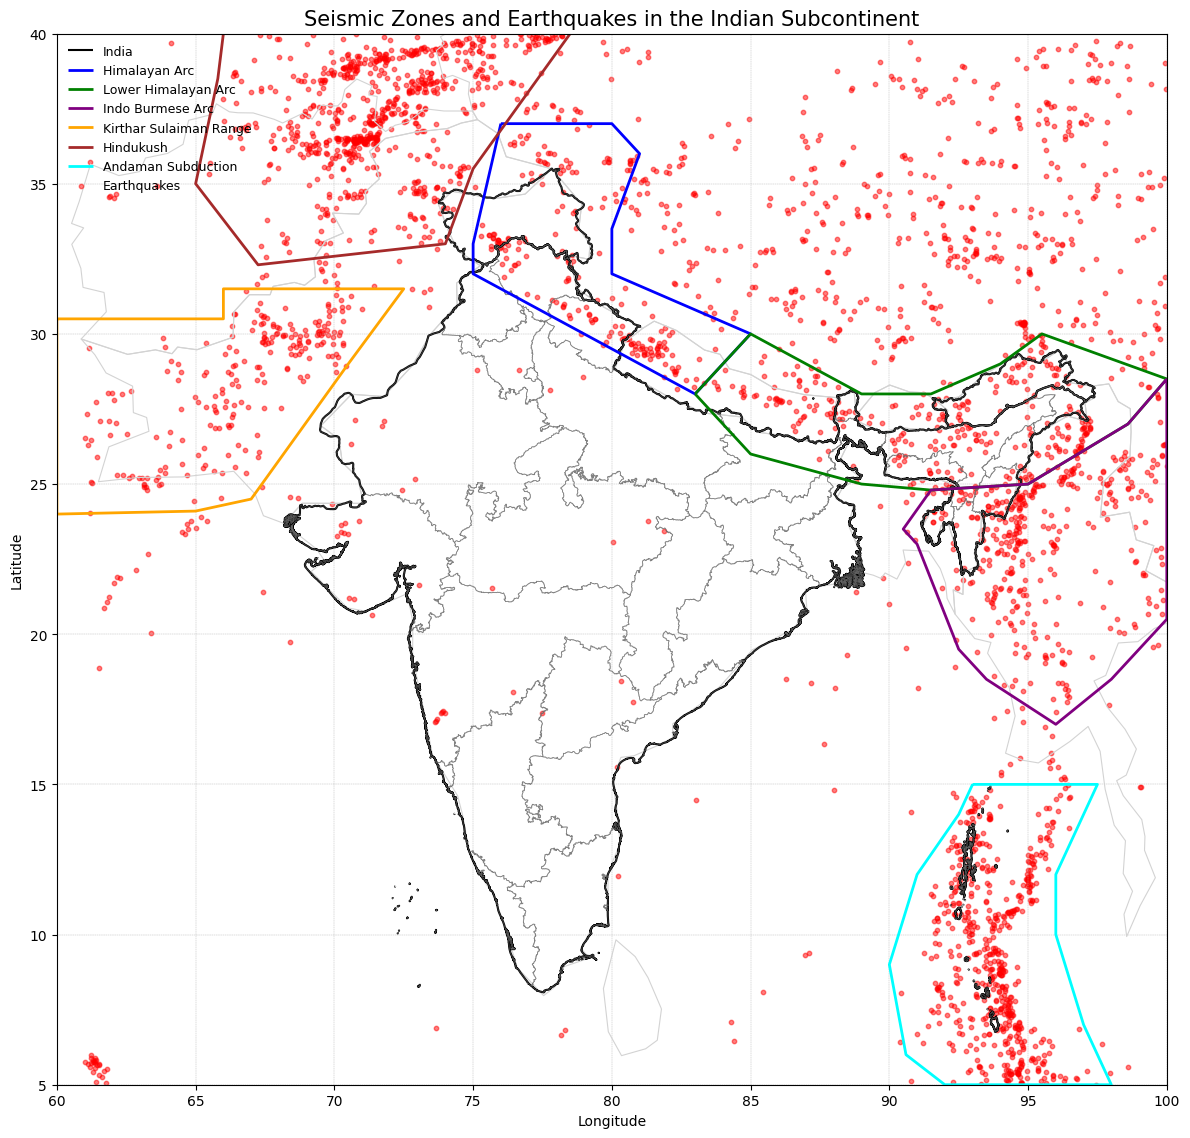

In [ ]:
# ==========================================================
#  Seismic zones, earthquake export, and India–subcontinent map
# ==========================================================
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import os

# -------------------------
# 1. LOAD & PREPARE EVENTS
# -------------------------
EQ_CSV = "final_2.csv"                   # earthquake catalogue
INDIA0  = "gadm41_IND_0.json"            # India outline (level 0)
INDIA1  = "gadm41_IND_1.json"            # India states  (level 1)
NE_SHAPE = "ne_110m_admin_0_countries.shp"  # Natural Earth shapefile

# read and clip catalogue
df = pd.read_csv(EQ_CSV, parse_dates=["date"])
df = df.query("5 <= latitude <= 40 and 60 <= longitude <= 100")
gdf_eq = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# --------------------------------------------
# 2. DEFINE SIX ZONE POLYGONS  (buffer to fix)
# --------------------------------------------
zones = {
    "Himalayan_Arc": Polygon([
        (76, 37), (80, 37), (81, 36), (80, 33.5), (80, 32),
        (85, 30), (83, 28), (79, 30), (75, 32), (75, 33), (76, 37)
    ]),
    "Lower_Himalayan_Arc": Polygon([
        (83, 28), (85, 30), (87, 29), (89, 28), (91.5, 28),
        (94, 29), (95.5, 30), (100, 28.5), (98.6, 27), (95, 25),
        (91.5, 24.8), (89, 25), (85, 26), (83, 28)
    ]),
    "Indo_Burmese_Arc": Polygon([
        (100, 28.5), (98.6, 27), (95, 25),
        (91.5, 24.8), (90.5, 23.5), (91, 23), (92.5, 19.5),
        (93.5, 18.5), (96, 17), (98, 18.5), (100, 20.5), (100, 28.5)
    ]),
    "Kirthar_Sulaiman_Range": Polygon([
        (60, 30.5), (66, 30.5), (66, 31.5), (72.5, 31.5), (70.5, 29),
        (67, 24.5), (65, 24.1), (60, 24), (60, 30.5)
    ]),
    "Hindukush": Polygon([
        (66, 40), (65.8, 38.5), (65, 35), (67.25, 32.3),
        (74, 33), (75, 35.5), (78.5, 40), (66, 40)
    ]),
    "Andaman_Subduction": Polygon([
        (93, 15), (97.5, 15), (96, 12), (96, 10), (97, 7), (98, 5),
        (92, 5), (90.6, 6), (90, 9), (91, 12), (92.5, 14), (93, 15)
    ])
}

# ------------------------------------------------
# 3. EXPORT ZONE-WISE CSVs  (edge points included)
# ------------------------------------------------
os.makedirs("zone_outputs", exist_ok=True)
for name, poly in zones.items():
    poly_fixed = poly.buffer(0)                       # repair if needed
    hits = gdf_eq.geometry.apply(poly_fixed.covers)   # includes boundary
    gdf_eq.loc[hits, ["date", "latitude", "longitude", "Mw"]].sort_values("date").to_csv(
        f"zone_outputs/{name}_earthquakes.csv", index=False
    )
    print(f"✅ {name}: {hits.sum()} events written")

# --------------------------------------------
# 4. PLOT INDIA, SUB-CONTINENT, ZONES, QUAKES
# --------------------------------------------
# Natural Earth outlines for nine countries
world   = gpd.read_file(NE_SHAPE).to_crs("EPSG:4326")
subregion = world[world["NAME"].isin([
    "India", "Nepal", "Pakistan", "Bangladesh", "Myanmar",
    "Bhutan", "Sri Lanka", "China", "Afghanistan"
])]

# India high-resolution boundaries
india0 = gpd.read_file(INDIA0).to_crs("EPSG:4326")
india1 = gpd.read_file(INDIA1).to_crs("EPSG:4326")

colors = ["blue", "green", "purple", "orange", "brown", "cyan"]
fig, ax = plt.subplots(figsize=(12, 14))

# sub-continent neighbours
subregion.boundary.plot(ax=ax, color="lightgray", linewidth=0.8, label="_nolegend_")

# India outline + states
india0.boundary.plot(ax=ax, color="black", linewidth=1.5, label="India")
india1.boundary.plot(ax=ax, color="dimgray", linewidth=0.6, alpha=0.6, label="_nolegend_")

# zone polygons
for (name, poly), c in zip(zones.items(), colors):
    gpd.GeoSeries([poly], crs="EPSG:4326").boundary.plot(
        ax=ax, color=c, linewidth=2, label=name.replace("_", " ")
    )

# epicentres
gdf_eq.plot(ax=ax, color="red", markersize=10, alpha=0.5, label="Earthquakes")

# map frame & labels
ax.set_xlim(60, 100)
ax.set_ylim(5, 40)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, linestyle="--", linewidth=0.3)
plt.title("Seismic Zones and Earthquakes in the Indian Subcontinent", fontsize=15)
plt.legend(loc="upper left", frameon=False, fontsize=9)
plt.tight_layout()
plt.show()
